# Procesamiento de datos del dataset

In [1]:
!git clone https://github.com/MatiasTelo/Global-Redes-Neuronales-Telo-Blangetti
# Crear carpetas de destino

print("Archivos copiados con éxito.")

Cloning into 'Global-Redes-Neuronales-Telo-Blangetti'...
remote: Enumerating objects: 82, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 82 (delta 33), reused 69 (delta 30), pack-reused 0 (from 0)
Receiving objects: 100% (82/82), 39.43 MiB | 11.13 MiB/s, done.
Resolving deltas: 100% (33/33), done.
Archivos copiados con éxito.


El procesamiento del dataset se realizo de la siguiente manera:



*   Primero definimos el vocabulario y creamos un diccionario para pasar de caracter a numero y viceversa
*   Luego obtenemos los txt descargados del dataset y los guardamos en una variable
*   Guardamos el diccionario de char to index
*   En prepare_segments lo que hacemos es dividir los txt primero en 14 filas para definir el alto del segmento y luego lo dividimos en 32 columnas para el ancho, nos aseguramos de llenar espacios si faltan y cada segmento se agrega al array de segments
*   En get item lo que hacemos es a cada segmento agregarle una dimension adicional del tamaño del vocabulario para hacer un one-hot de cada caracter


Adicionalmente agregamos una funcion para visualizar los segmentos que nos devuelve el dataset que nos sirve de utilidad para ver que todo se haya procesado bien y ademas para cuando generemos segmentos con la gan tambien podamos usar esta funcion para verlos



In [2]:

import glob
import torch.nn.functional as F
import os
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np

# Definir el vocabulario
CHARACTER_SET = ['X', 'S', '-', '?', 'Q', 'E', '<', '>', '[', ']', 'o', 'B', 'b']
char2idx = {char: idx for idx, char in enumerate(CHARACTER_SET)}
idx2char = {idx: char for char, idx in char2idx.items()}
VOCAB_SIZE = len(CHARACTER_SET)

class MarioLevelDataset(Dataset):
    def __init__(self, folder_path, level_height=14, segment_width=32, step=16, char2idx=None):
        super().__init__()
        self.level_files = glob.glob(os.path.join(folder_path, '*.txt'))
        self.level_height = level_height
        self.segment_width = segment_width
        self.step = step

        # Mapa char->idx obligatorio
        if char2idx is None:
            raise ValueError("Debes pasar un diccionario char2idx")
        self.char2idx = char2idx

        # Aquí guardamos todos los segmentos de todos los niveles
        self.segments = []
        self._prepare_segments()

    def _prepare_segments(self):
        for file_path in self.level_files:
            with open(file_path, 'r') as f:
                lines = f.readlines()
            # Limpio líneas y fijo altura
            lines = [line.rstrip('\n')[:] for line in lines[:self.level_height]]
            # Completo si faltan filas
            while len(lines) < self.level_height:
                lines.append('-' * len(lines[0]))

            level_width = max(len(line) for line in lines)
            # Completo cada línea a nivel_width (con '-')
            lines = [line.ljust(level_width, '-') for line in lines]

            # Segmentar horizontalmente con step
            for start_col in range(0, level_width - self.segment_width + 1, self.step):
                segment = [line[start_col:start_col+self.segment_width] for line in lines]
                self.segments.append(segment)

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
      segment = self.segments[idx]
      arr = [[self.char2idx.get(ch, 0) for ch in row] for row in segment]
      tensor = torch.tensor(arr, dtype=torch.long)
      one_hot = F.one_hot(tensor, num_classes=len(self.char2idx))  # (14, 32, vocab)
      one_hot = one_hot.permute(2, 0, 1)  # -> (vocab, 14, 32)
      return one_hot.float()


In [3]:
# Rutas y parámetros
data_path = 'Global-Redes-Neuronales-Telo-Blangetti/data/Processed'
batch_size = 32
train_ratio = 0.8

# Cargar dataset
dataset = MarioLevelDataset(folder_path=data_path, char2idx=char2idx)
# DataLoaders
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)


# Visualizacion de segmentos

In [4]:
def visualizar_segmento(one_hot_tensor, idx2char):
    """
    Convierte un tensor one-hot (VOCAB_SIZE, 14, 32) a texto y lo imprime.
    """
    # (VOCAB_SIZE, 14, 32) → (14, 32) con los índices de mayor probabilidad
    idx_tensor = one_hot_tensor.argmax(dim=0).cpu().numpy()

    # Convertir cada índice a su carácter correspondiente
    for row in idx_tensor:
        line = ''.join(idx2char[i] for i in row)
        print(line)



In [5]:

# Elegí un índice de segmento, por ejemplo el primero
segmento = dataset[347]  # (VOCAB_SIZE, 14, 32)

# Visualizarlo
visualizar_segmento(segmento, idx2char)


--------------------------------
--------------------------------
--------------------------------
---------------E--XXX----XXX----
--------------------------------
--------------------------------
--oooo---------X----------------
--oooo--------------------------
--------XXX---------------------
--------------------------------
XXXXXXX-------------------------
X-------------------------------
X-------------------------------
--------------------------------


# Utilidad para visualizacion

In [9]:
from PIL import Image
import os

def cargar_sprites(path="Global-Redes-Neuronales-Telo-Blangetti/data/Sprites"):
    """
    Carga las imágenes PNG de tiles en un diccionario: {char: PIL.Image}
    """
    sprites = {}
    for filename in os.listdir(path):
        if filename.endswith(".png"):
            key = os.path.splitext(filename)[0]  # nombre sin extensión
            if key == "D":
                key = "<"
            elif key == "I":
                key = ">"
            elif key == "P":
                key = "B"
            elif key == "A":
                key = "?"
            sprites[key] = Image.open(os.path.join(path, filename)).convert("RGBA")
    return sprites


In [10]:
import numpy as np
from PIL import Image

def tensor_a_imagen(one_hot_tensor, idx2char, sprites, tile_size=(16, 16)):
    """
    Convierte un tensor one-hot (VOCAB_SIZE, 14, 32) en una imagen compuesta de sprites.
    """
    idx_tensor = one_hot_tensor.argmax(dim=0).cpu().numpy()  # (14, 32)

    rows, cols = idx_tensor.shape
    tile_width, tile_height = tile_size

    # Crear imagen en blanco del tamaño total
    output = Image.new('RGBA', (cols * tile_width, rows * tile_height))

    for y in range(rows):
        for x in range(cols):
            char = idx2char[idx_tensor[y][x]]
            sprite = sprites.get(char, None)
            if sprite:
                output.paste(sprite, (x * tile_width, y * tile_height), mask=sprite)
    return output


Forma de fake2: torch.Size([13, 14, 32])


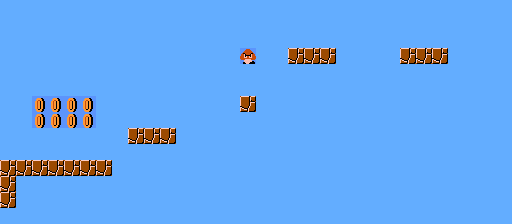

In [12]:
sprites = cargar_sprites()
# Verificar primero la forma
print(f"Forma de fake2: {segmento.shape}")

imagen_resultado = tensor_a_imagen(segmento, idx2char, sprites)
display(imagen_resultado)